### Step 0: Load the image of German Traffic Sign and examine the data image is correct

In [1]:
## import tensorflow ,numpy,etc. 
import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import flatten

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../data/train.p'
validation_file = '../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
print('X_train.shape:',X_train.shape)
X_valid, y_valid = valid['features'], valid['labels']
print('X_valid.shape:',X_valid.shape)
X_test, y_test = test['features'], test['labels']
print('X_test.shape:',X_test.shape)

X_train.shape: (34799, 32, 32, 3)
X_valid.shape: (4410, 32, 32, 3)
X_test.shape: (12630, 32, 32, 3)


In [3]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
### https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
#matplotlib inline

index = random.randint(0, len(X_train))
print('random index',index)
image = X_train[index].squeeze()
print('image.shape:',image.shape)

w = 10
h = 10
fig = plt.figure(figsize=(9, 13))
columns = 4
rows = 5
ax = []

for i in range( columns*rows ):
    #img = np.random.randint(10, size=(h,w))  
    index = random.randint(0, len(X_train))
    img = X_train[index].squeeze()
    
    # create subplot and append to ax
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title("ax:"+str(i))  # set title
    plt.imshow(img, alpha=0.25)

plt.show()  # finally, render the plot

random index 25582
image.shape: (32, 32, 3)


----
## Step 1: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.



### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, (pixel - 128)/ 128 is a quick way to approximately normalize the data and can be used in this project.

Other pre-processing steps are optional. You can try different techniques to see if it improves performance.

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.


In [4]:
# image centering for image pre-processing
def center(X):
    newX = X - np.mean(X, axis = 0)
    return newX

In [5]:
# whitening, but poor result for pre-processing 
def whiten(X):
    #newX = center(X)
    cov = X.T.dot(X)/float(X.shape[0])
    # Calculate the eigenvalues and eigenvectors of the covariance matrix
    eigVals, eigVecs = np.linalg.eig(cov)
    # Apply the eigenvectors to X
    decorrelated = X.dot(eigVecs)
    # Rescale the decorrelated data
    whitened = decorrelated / np.sqrt(eigVals + 1e-5)
    return whitened

In [6]:
# normalization for pre-processing
def normCNN(X):
    X = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
    # normalization
    X_norm = (X-256)/256
    # centeralization
    #X_norm = X_norm - X_norm.mean(axis=0)
    # standardization
    #X_norm = X_norm/np.std(X_norm, axis = 0)
    # rescaling to set between 0 and 1    
    return X_norm

In [7]:
# rescaling
def RescaleCNN(X):
    X_rescaled = (X - X.min()) / (X.max() - X.min())
    
    return X_rescaled

In [8]:
def reScaledback(X):
    X_reScaled = X.reshape(-1,32,32,3)
    return X_reScaled    

In [9]:
X_train = normCNN(X_train)
X_valid = normCNN(X_valid)
X_test = normCNN(X_test)

In [10]:
#X_train = whiten(X_train)
#X_valid = whiten(X_valid)
#X_test = whiten(X_test)

In [11]:
# do I need this? Feb092018, without rescaling, the accuracy is at 70%.... 
X_train = RescaleCNN(X_train)
X_valid = RescaleCNN(X_valid)
X_test = RescaleCNN(X_test)

In [12]:
X_train = reScaledback(X_train)
X_valid = reScaledback(X_valid)
X_test = reScaledback(X_test)

In [13]:
# recheck the data shape
X_train.shape

(34799, 32, 32, 3)

In [14]:
# graying out
X_train = X_train.mean(axis=-1,keepdims=1) 
X_valid = X_valid.mean(axis=-1,keepdims=1)
X_test = X_test.mean(axis=-1,keepdims=1)
X_train.shape

(34799, 32, 32, 1)

In [15]:
# plotting custom function 
def plotImage(X):
    plt.figure(figsize = (1.5,1.5))
    plt.imshow(X.reshape(32,32))
    plt.show()
    plt.close()

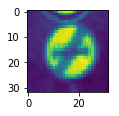

In [16]:
# plot an image to see if things are done correctly 
plotImage(X_train[12,:])

In [17]:
# classID and signal name extraction
import pandas as pd
my_csv = pd.read_csv('signnames.csv')
ClassId_Name = my_csv.ClassId
Sign_Name = my_csv.SignName

print(len(ClassId_Name))

43


In [18]:
# extract the number of images. 
### 34,799 of the dataset images were used as a training dataset,
### 12,630 of the images were used as a testing dataset, 
### and 4,410 of the images were used as a validation dataset.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid) 

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape
# print("Image Shape: {}".format(X_train[0].shape))

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(ClassId_Name)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (34799, 32, 32, 1)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [19]:
## testing the shape of an image
img_reshape = X_train[12,:].reshape(-1,32,32,1)
print(img_reshape.shape)

(1, 32, 32, 1)


In [20]:
img_reshape = tf.cast(img_reshape,tf.float32)
print(img_reshape.shape)

(1, 32, 32, 1)


Tensor("Conv2D:0", shape=(1, 16, 16, 5), dtype=float32)


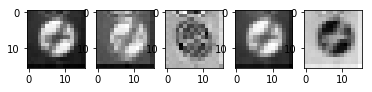

In [21]:
# testing one image under tensorflow interactive session
# convlution layer image

sess = tf.InteractiveSession()
#img = img.reshape(-1,28,28,1)
W1 = tf.Variable(tf.random_normal([3,3,1,5],stddev = 0.01))
conv2d = tf.nn.conv2d(img_reshape,W1,strides = [1,2,2,1],padding = 'SAME')
print(conv2d)
sess.run(tf.global_variables_initializer())
conv2d_img = conv2d.eval()
conv2d_img = np.swapaxes(conv2d_img,0,3)
for i, one_img in enumerate(conv2d_img):
    # plt.subplot(1,5,i+1), plt.imshow(one_img.reshape(14,14),cmap ='gray')
    plt.subplot(2,5,i+1), plt.imshow(one_img.reshape(16,16),cmap ='gray')

Tensor("MaxPool:0", shape=(1, 8, 8, 5), dtype=float32)


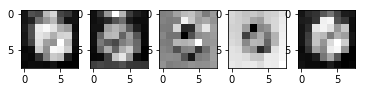

In [22]:
# check maxpooling image
# max pool image
pool = tf.nn.max_pool(conv2d,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')
print(pool)
sess.run(tf.global_variables_initializer())
pool_img = pool.eval()
pool_img = np.swapaxes(pool_img,0,3)
for i, one_img in enumerate(pool_img):
    plt.subplot(1,5,i+1),plt.imshow(one_img.reshape(8,8),cmap = 'gray')
    #plt.subplot(1,5,i+1),plt.imshow(one_img.reshape(7,7),cmap = 'gray')

### Train, Validate, and test the model 

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [33]:
# define parameters i.e. learning rate, epochs, and batch sizes
learning_rate = 0.001
training_epochs = 25
batch_size = 100

EPOCHS = training_epochs
BATCH_SIZE = batch_size

In [34]:
# setting placeholders

X = tf.placeholder(tf.float32, (None, 32, 32, 1))
Y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(Y, n_classes)

In [35]:
print('Y:',Y)
print('one_hot_y:',one_hot_y)

Y: Tensor("Placeholder_4:0", dtype=int32)
one_hot_y: Tensor("one_hot_1:0", dtype=float32)


In [36]:
is_training = tf.placeholder(tf.bool)

In [37]:
def LeNet2(X):
    
    L1 = tf.layers.conv2d(X,32,[3,3],activation=tf.nn.relu,padding = 'SAME')
    #print(L1)
    L1 = tf.layers.max_pooling2d(L1,[2,2],[2,2],padding = 'SAME')
    #print(L1)
    #W1 = tf.Variable(tf.random_normal([3,3,1,32],stddev = 0.01))
    #L1 = tf.nn.conv2d(x,W1,strides = [1,1,1,1],padding = 'SAME')
    #L1 = tf.nn.relu(L1)
    #L1 = tf.nn.max_pool(L1,ksize=[1,2,2,1],strides = [1,2,2,1],padding = 'SAME')
    #L1 = tf.nn.dropout(L1,keep_prob)
    
    L2 = tf.layers.conv2d(L1,64,[3,3],activation= tf.nn.relu,padding = 'SAME')
    #print(L2)
    L2 = tf.layers.max_pooling2d(L2,[2,2],[2,2],padding = 'SAME')
    #print(L2)
    
    
    #L3 = tf.layers.conv2d(L1,128,[3,3],activation= tf.nn.relu,padding = 'SAME')
    #print(L3)
    #L3 = tf.layers.max_pooling2d(L3,[2,2],[2,2],padding = 'SAME')
    #print(L3)
    
    
    L3 = tf.contrib.layers.flatten(L2)
    #print(L4)
    L3 = tf.layers.dense(L3,256,activation = tf.nn.relu)
    #print(L4)
    L3 = tf.layers.dropout(L3,0.5,is_training)
    
    logits = tf.layers.dense(L3,n_classes,activation = None)
    #print(model)
    
    return logits
    

In [38]:

logits = LeNet2(X)
print(logits)
#logits = LeNet2(x)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits))
#loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
#training_operation = optimizer.minimize(cost)


Tensor("dense_4/BiasAdd:0", shape=(?, 43), dtype=float32)


In [39]:
# model evaluation 
is_correct = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))
#print('accuracy',sess.run(accuracy,feed_dict={X:X_valid,Y: y_valid,is_training:False}))

#  evaluation of training
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    #print('num_examples:',num_examples)
    total_accuracy = 0
    #sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy_cal = sess.run(accuracy, feed_dict={X: batch_x, Y: batch_y, is_training:False})
        total_accuracy += (accuracy_cal * len(batch_x))
    return total_accuracy / num_examples

### - Train

In [40]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
saver = tf.train.Saver()

In [41]:
from sklearn.utils import shuffle

#X_train, y_train = shuffle(X_train, y_train)

In [43]:
#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
num_examples = len(X_train)   
print("Training...")
print()
validation_accuracy_figure = []   
test_accuracy_figure = []
for epoch in range(EPOCHS):
    X_train, y_train = shuffle(X_train, y_train)
    total_cost = 0
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_train[offset:end], y_train[offset:end]
        _,cost_val = sess.run([optimizer,cost], feed_dict={X: batch_x, Y: batch_y, is_training:True})
        total_cost+= cost_val
    
    
    validation_accuracy = evaluate(X_valid,y_valid)
    validation_accuracy_figure.append(validation_accuracy)
    
    test_accuracy = evaluate(X_train,y_train)
    test_accuracy_figure.append(test_accuracy)
    
    #print('Epoch:','%04d' % (epoch+1),'Avg.cost =','{:.3f}'.format(total_cost/BATCH_SIZE))
    print('Epoch:','%04d' % (epoch+1))
    print('Test Accuracy =','{:.3f}'.format(test_accuracy))
    print('Validation Accuracy =','{:.3f}'.format(validation_accuracy))
    
    
print('optimization completes')        
       # validation_accuracy = evaluate(X_valid, y_valid)
       # print("EPOCH {} ...".format(i+1))
       # print("Validation Accuracy = {:.3f}".format(validation_accuracy))
       # print()
        
saver.save(sess, './lenet')
print("Model saved")
    
    # session closure. is it okay without close? I have seen many of codes without session close. 
    # found that 'with' function for session will close the session automatically?
#sess.close()

Training...

Epoch: 0001
Test Accuracy = 1.000
Validation Accuracy = 0.939
Epoch: 0002
Test Accuracy = 1.000
Validation Accuracy = 0.941
Epoch: 0003
Test Accuracy = 0.969
Validation Accuracy = 0.865
Epoch: 0004
Test Accuracy = 0.996
Validation Accuracy = 0.928
Epoch: 0005
Test Accuracy = 0.999
Validation Accuracy = 0.939
Epoch: 0006
Test Accuracy = 1.000
Validation Accuracy = 0.945
Epoch: 0007
Test Accuracy = 1.000
Validation Accuracy = 0.944
Epoch: 0008
Test Accuracy = 1.000
Validation Accuracy = 0.945
Epoch: 0009
Test Accuracy = 1.000
Validation Accuracy = 0.943
Epoch: 0010
Test Accuracy = 1.000
Validation Accuracy = 0.944
Epoch: 0011
Test Accuracy = 1.000
Validation Accuracy = 0.945
Epoch: 0012
Test Accuracy = 1.000
Validation Accuracy = 0.944
Epoch: 0013
Test Accuracy = 1.000
Validation Accuracy = 0.944
Epoch: 0014
Test Accuracy = 0.985
Validation Accuracy = 0.892
Epoch: 0015
Test Accuracy = 0.998
Validation Accuracy = 0.941
Epoch: 0016
Test Accuracy = 1.000
Validation Accuracy = 0

In [44]:
'''
Feb182019: received a feedback upon submission of work, found that all data () train/validation/test data) needs pre-processing. 
So far, I only applied pre-processing on train data set... 
achieved 94% accuracy with validation data. 

'''

'\nFeb182019: received a feedback upon submission of work, found that all data () train/validation/test data) needs pre-processing. \nSo far, I only applied pre-processing on train data set... \nachieved 94% accuracy with validation data. \n\n'

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

## Load example image

In [45]:
## Goddard's jupyter notes: https://github.com/Goddard/udacity-traffic-sign-classifier/blob/master/Traffic_Sign_Classifier.ipynb
def plot_figures(figures, nrows = 1, ncols=1, labels=None):
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(12, 14))
    axs = axs.ravel()
    for index, title in zip(range(len(figures)), figures):
        axs[index].imshow(figures[title], plt.gray())
        if(labels != None):
           axs[index].set_title(labels[index])
        else:
            axs[index].set_title(title)
            
        axs[index].set_axis_off()
        
    plt.tight_layout()

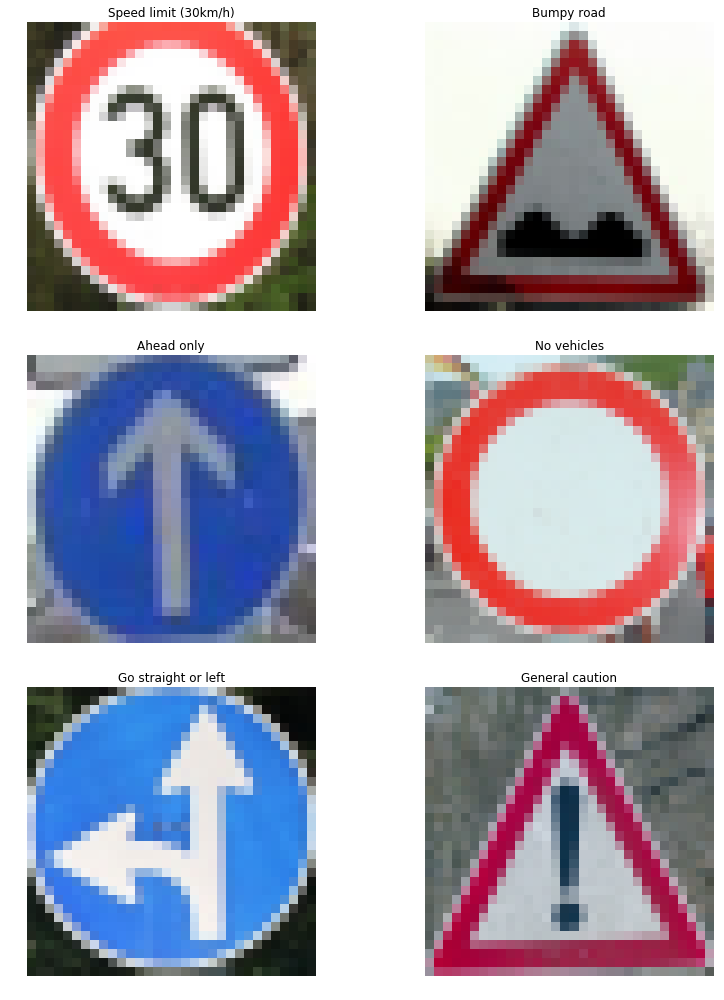

In [46]:
'''

1/ 28: children crossing
2/27: pedestrians
3/12: priority road
4/23: slippery road
5/4: Speed limit (70km/h)
6/14: stop
'''
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import cv2
name_values = np.genfromtxt('signnames.csv', skip_header=1, dtype=[('myint','i8'), ('mysring','S55')], delimiter=',')

my_images = sorted(glob.glob('./mysigns/*.png'))
#my_labels = np.array([28, 27, 12, 23, 4, 14])
my_labels = np.array([1, 22, 35, 15, 37, 18])

figures = {}
labels = {}
my_signs = []
index = 0
for my_image in my_images:
    img = cv2.cvtColor(cv2.imread(my_image), cv2.COLOR_BGR2RGB)
    my_signs.append(img)
    figures[index] = img
    labels[index] = name_values[my_labels[index]][1].decode('ascii')
    index += 1

plot_figures(figures, 3, 2, labels)

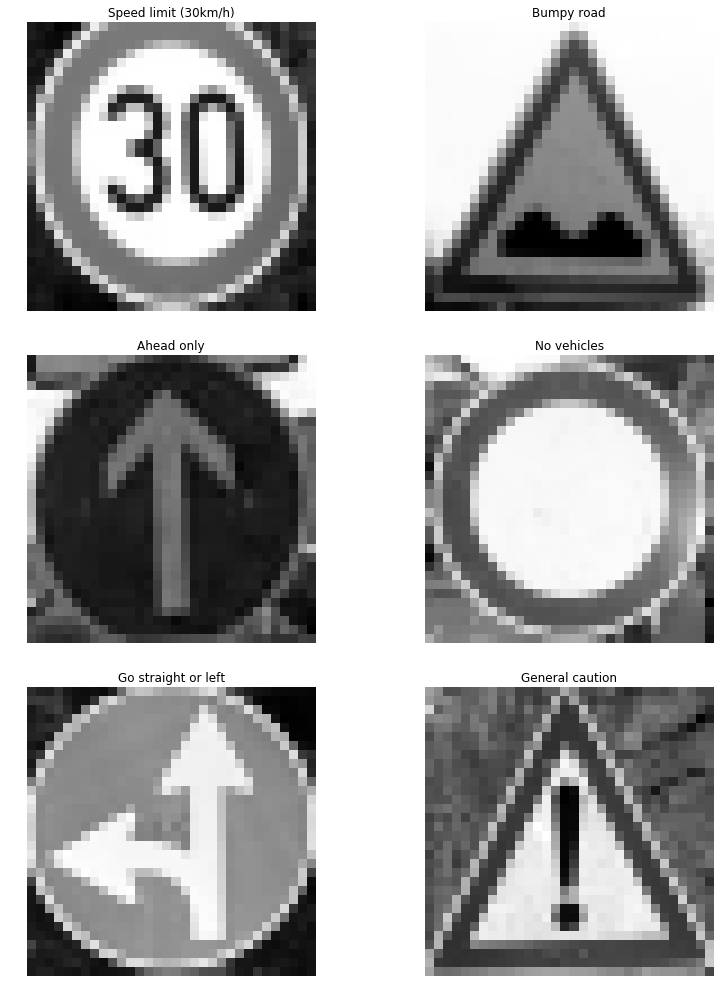

In [47]:
### preprocessing it doesn't work, axis =3 out of bound error appear. 

my_signs = np.array(my_signs)
my_signs_gray = np.sum(my_signs/3, axis=3, keepdims=True)
my_signs_normalized = my_signs_gray/128-1

my_signs_gray[1] = my_signs[1].mean(axis=-1,keepdims=1) 

number_to_stop = 6
figures = {}
labels = {}
for i in range(number_to_stop):
    labels[i] = name_values[my_labels[i]][1].decode('ascii')
    figures[i] = my_signs_gray[i].squeeze()
    
plot_figures(figures, 3, 2, labels)

### predict the sign type for each image

In [48]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    saver = tf.train.import_meta_graph('./lenet.meta')
#    saver.restore(sess, "./lenet")
my_accuracy = evaluate(my_signs_normalized, my_labels)
print("My Data Set Accuracy = {:.3f}".format(my_accuracy))

My Data Set Accuracy = 1.000


### Analyze performance

In [49]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
my_single_item_array = []
my_single_item_label_array = []

for i in range(6):
    my_single_item_array.append(my_signs_normalized[i])
    my_single_item_label_array.append(my_labels[i])

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
#         saver = tf.train.import_meta_graph('./lenet.meta')
        saver.restore(sess, "./lenet")
        my_accuracy = evaluate(my_single_item_array, my_single_item_label_array)
        print('Image {}'.format(i+1))
        print("Image Accuracy = {:.3f}".format(my_accuracy))
        print()

INFO:tensorflow:Restoring parameters from ./lenet
Image 1
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 2
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 3
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 4
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 5
Image Accuracy = 1.000

INFO:tensorflow:Restoring parameters from ./lenet
Image 6
Image Accuracy = 1.000



### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ./lenet


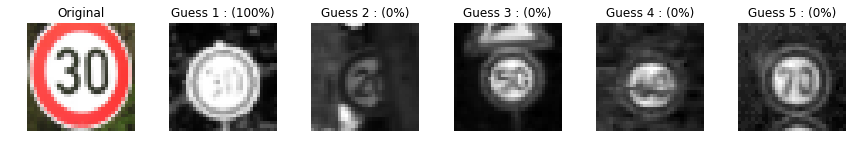

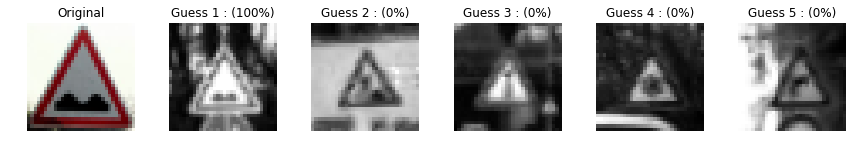

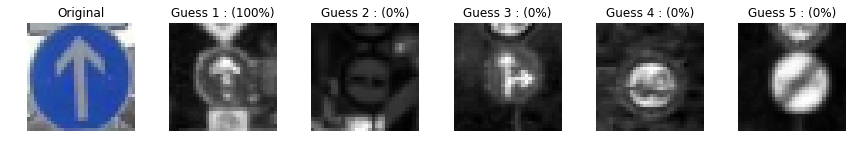

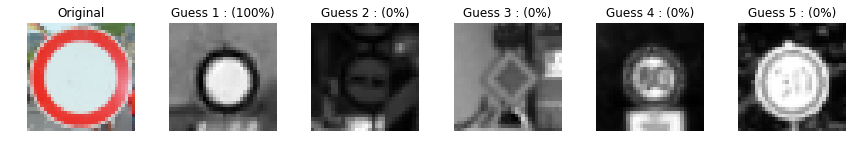

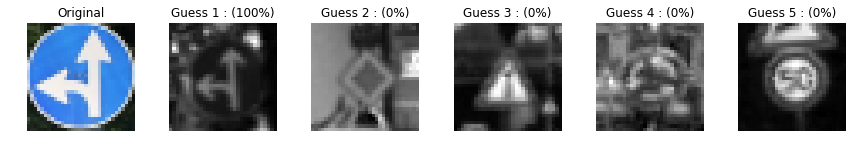

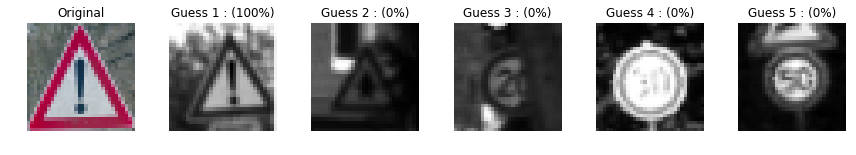

In [50]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
k_size = 5
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=k_size)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    my_saver = tf.train.import_meta_graph('./lenet.meta')
    saver.restore(sess, "./lenet")
    my_softmax_logits = sess.run(softmax_logits, feed_dict={X: my_signs_normalized, is_training:False})
    my_top_k = sess.run(top_k, feed_dict={X: my_signs_normalized, is_training:False})
#     print(my_top_k)

    for i in range(6):
        figures = {}
        labels = {}
        
        figures[0] = my_signs[i]
        labels[0] = "Original"
        
        for j in range(k_size):
#             print('Guess {} : ({:.0f}%)'.format(j+1, 100*my_top_k[0][i][j]))
            labels[j+1] = 'Guess {} : ({:.0f}%)'.format(j+1, 100*my_top_k[0][i][j])
            figures[j+1] = X_valid[np.argwhere(y_valid == my_top_k[1][i][j])[0]].squeeze()
            
#         print()
        plot_figures(figures, 1, 6, labels)

### Project Writeup

a. spent quite a time to carry pre-processing. somehow, centralization/standardization gives me the worse result. 
b. I am not completely grasp tensorflow session class, especially with jupyter. one thing I am not able to get is, it is okay witout session.close statement. 
c. I am not able to achieve >90% of accuracy with validation data set (nearly 90% only) with given learning layer set up whilst training dataset gives nearly 100% accuracy. 
d. It is stiff learning curve to get used to CNN for deep learning. 
e. I referred to few codes sample from stackoverflow website and one of work available in github for the credit: 
https://github.com/Goddard/udacity-traffic-sign-classifier
f. I referred to few other books (a book was helpful mainly to get a good understanding of the training algorithm:https://play.google.com/books/reader?id=GXg3DwAAQBAJ)





> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")